# Generate synthetic testcase for similarity ranking using a Supervised Random Walk with Restarts [Backstrom et al] implemented in Pytorch 

In [2]:
import random
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from torchviz import make_dot
import importlib
import algorithms.ranker
import algorithms.grad_descent
importlib.reload(algorithms.grad_descent)
importlib.reload(algorithms.ranker)
from algorithms.ranker import Ranker
from algorithms.grad_descent import GradDescent
import time

## Generate full synthetic graph with edge attributes as one-hot-encoding of 'colours' with the following key [red, green, blue, yellow, orange]
### e.g. a 'red' edge would encoded as [1, 0, 0, 0, 0]

### First generate a feature matrix, where each element of the matrix a_ij represents the edge attribute vector from node i to node j, with the graph structure (i.e. adjacency matrix structure) inherent. 

In [3]:
device = 'cuda' if th.cuda.is_available() else 'cpu'

# Generate random adjacency matrix
nnodes = 5000
ntrain = 100
nfeats = 5

rand_m = th.empty(nnodes, nnodes, dtype=th.float, device=device).uniform_(0,1)
adj_m = th.bernoulli(rand_m)

# Generate random colour features for each present edge
feat_matrix = th.zeros(nnodes, nnodes, nfeats, dtype=th.float, device=device)
it = 0
for i in range(nnodes):
    for j in range(nnodes):
        feat_vect = th.zeros(nfeats, dtype=th.float, device=device)
        if adj_m[i,j]==1:
            rand = random.randint(0,4)
            feat_vect[rand]+=1
            feat_matrix[i,j] = feat_vect
        else:
            feat_matrix[i,j] = feat_vect
    if it%100==0:
        print('{} rows loaded'.format(it))
    it += 1


0 rows loaded
100 rows loaded
200 rows loaded
300 rows loaded
400 rows loaded
500 rows loaded
600 rows loaded
700 rows loaded
800 rows loaded
900 rows loaded
1000 rows loaded
1100 rows loaded
1200 rows loaded
1300 rows loaded
1400 rows loaded
1500 rows loaded
1600 rows loaded
1700 rows loaded
1800 rows loaded
1900 rows loaded
2000 rows loaded
2100 rows loaded
2200 rows loaded
2300 rows loaded
2400 rows loaded
2500 rows loaded
2600 rows loaded
2700 rows loaded
2800 rows loaded
2900 rows loaded
3000 rows loaded
3100 rows loaded
3200 rows loaded
3300 rows loaded
3400 rows loaded
3500 rows loaded
3600 rows loaded
3700 rows loaded
3800 rows loaded
3900 rows loaded
4000 rows loaded
4100 rows loaded
4200 rows loaded
4300 rows loaded
4400 rows loaded
4500 rows loaded
4600 rows loaded
4700 rows loaded
4800 rows loaded
4900 rows loaded


## Random Test Case
### Firstly, examine the similarity ranking of the full synthetic graph with the 'bias' nodes, achieved by performing a Personalised PageRank with random weights. The performance of the similarity ranking will be analysed by considering a graph outlining the fraction of the bias nodes found to be ranked highest in the whole set. 

Loading graph PageRank...


No handles with labels found to put in legend.
No handles with labels found to put in legend.


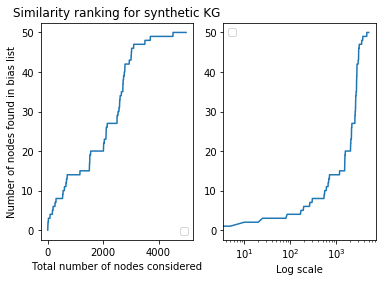

In [16]:
# Initialise random weights
rand_weights = th.rand(nfeats, dtype=th.float, device=device)

# Full personalised PageRank on whole data set using random 'optimised' weights
print('Loading graph PageRank...')
source_node = random.randint(0, nnodes)
full_ranker = Ranker(nnodes, nfeats, rand_weights, feat_matrix, device)
rw_matrix = full_ranker.rw_matrix()
p_scores = full_ranker.rwr_iter(rw_matrix, source_node)
p_scores = th.transpose(p_scores, 0, 1)

# Order PageRank scores in descending order
scores_i = {i: p_scores[i] for i in range(nnodes)}
new_ranking = sorted(scores_i, key=scores_i.get, reverse=True)

# Check graph of bias node ranking 
step = 0
steps = []
intersection = []
bias_nodes = set(range(ntrain//2))
while step < nnodes:
    steps.append(step)
    numb = len(set(new_ranking[:step]).intersection(bias_nodes))
    intersection.append(numb)
    step += 5

#Plot graph
fig, axes = plt.subplots(1, 2)

axes[0].plot(steps, intersection)
axes[1].plot(steps, intersection)

axes[0].legend(loc='lower right')
axes[0].set_xlabel('Total number of nodes considered')
axes[0].set_ylabel('Number of nodes found in bias list')
axes[0].set_title('Similarity ranking for synthetic KG')
axes[1].set_xlabel('Log scale')
axes[1].legend(loc='upper left')
axes[1].set_xscale('log')
plt.show()

## Bias Test Case

### From full graph introduce a specific bias for the first |ntrain|/2 nodes, which will be considered as the positive destination nodes when performing the random walk with restarts. Then examine similarity ranking using truly optimised weights.

Loading optimised weights...
Epoch=0, f_w=tensor([-0.0190], grad_fn=<AddBackward0>), weights=tensor([0., 0., 0., 0., 0.], requires_grad=True), grad=tensor([-1533.3270,   168.6996,   166.9496,   178.1496,   163.4496]) (0.7445230484008789s)
Epoch=1, f_w=tensor([-1950.8800], grad_fn=<AddBackward0>), weights=tensor([ 1.5333, -0.1687, -0.1669, -0.1781, -0.1634], requires_grad=True), grad=tensor([-783.2157,   80.2567,   76.7123,   81.0393,   76.9842]) (0.7883939743041992s)
Epoch=2, f_w=tensor([-2721.6763], grad_fn=<AddBackward0>), weights=tensor([ 3.3899, -0.3670, -0.3605, -0.3839, -0.3548], requires_grad=True), grad=tensor([-151.0500,   13.9053,   13.1359,   13.7162,   13.1855]) (0.7883741855621338s)
Epoch=3, f_w=tensor([-2841.5386], grad_fn=<AddBackward0>), weights=tensor([ 4.8405, -0.5198, -0.5092, -0.5416, -0.5020], requires_grad=True), grad=tensor([-34.7430,   2.8884,   2.7268,   2.8180,   2.7326]) (0.808480978012085s)
Epoch=4, f_w=tensor([-2864.2554], grad_fn=<AddBackward0>), weights=t

No handles with labels found to put in legend.
No handles with labels found to put in legend.


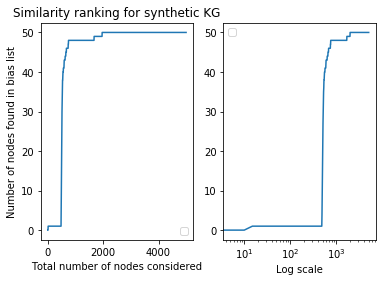

In [10]:
# Introduce bias for first |nnodes|/2 nodes in graph, where all edges to the bias nodes are 'red' (equivalent to the vector [1,0,0,0,0])
train_feat = feat_matrix
train_feat[0:ntrain-1,0:(ntrain//2)-1,:] = th.tensor([1, 0, 0, 0, 0], dtype=th.float, device=device)

# Biased synthetic training data set for first ntrain nodes
train_feat = th.narrow(train_feat, 0, 0, ntrain)
train_feat = th.narrow(train_feat, 1, 0, ntrain)  

# Limiting index for bias nodes
limit_ind = int(ntrain//2)

# Find optimised weights for training set
print('Loading optimised weights...')
bias_train = GradDescent(train_feat, device, limit_ind)
opt_weights = bias_train.grad_iterator()
print('Optimised weights are {}'.format(opt_weights))

# Full personalised PageRank on whole data set using optimised weights
print('Loading graph PageRank...')
source_node = random.randint(0, nnodes)
full_ranker = Ranker(nnodes, nfeats, opt_weights, feat_matrix, device)
rw_matrix = full_ranker.rw_matrix()
p_scores = full_ranker.rwr_iter(rw_matrix, source_node) 
p_scores = th.transpose(p_scores, 0, 1)

# Order PageRank scores in descending order
scores_i = {i: p_scores[i] for i in range(nnodes)}
new_ranking = sorted(scores_i, key=scores_i.get, reverse=True)

# Check graph of bias node ranking 
step = 0
steps = []
intersection = []
bias_nodes = set(range(ntrain//2))
while step < nnodes:
    steps.append(step)
    numb = len(set(new_ranking[:step]).intersection(bias_nodes))
    intersection.append(numb)
    step += 5

#Plot graph
fig, axes = plt.subplots(1, 2)

axes[0].plot(steps, intersection)
axes[1].plot(steps, intersection)

axes[0].legend(loc='lower right')
axes[0].set_xlabel('Total number of nodes considered')
axes[0].set_ylabel('Number of nodes found in bias list')
axes[0].set_title('Similarity ranking for synthetic KG')
axes[1].set_xlabel('Log scale')
axes[1].legend(loc='upper left')
axes[1].set_xscale('log')
plt.show()